In [53]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from gurobipy import *

In [54]:
pd.options.plotting.backend = "plotly"
template = "plotly_white"
profile= pd.read_csv("../data/SBAP_FCR_profile_test2.csv", index_col=0, parse_dates=True)
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_MPC.csv"
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_EqualDist.csv"
path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_ConsqDist.csv"
#path_output= r"C:\Users\tanjavov\Documents\Documents\KIMBAT PDS\kimbat-pds\ires-pds\output_ruleBased.csv"

#profile = pd.read_csv(path_profile, index_col=0, parse_dates=True)
output= pd.read_csv(path_output)

#profile.plot(template=template, labels={"value": "Current x100 [A]"})

In [55]:
parameters = {
"storage_params_1" : {
    "capacity": 1960,  # Ah
    "power": 87.8, #kWh
    
    "soc_bounds": (0.1, 0.9),
    "soc_start": 0.6,

    "string_count":1666, # descaling factor
    "module_count":7,

    "cell_count":14,
    "cell_resistance":0.033,

    "effc": 0.9,     # charge efficiency
    "effd": 0.9,     # discharge efficiency
},


"storage_params_2" : {
    "capacity": 1960,  # Ah
    "power": 87.8, #kWh

    "soc_bounds": (0.1, 0.9),
    "soc_start": 0.3,

    "string_count":1666,  # descaling factor
    "module_count":7,
    
    "cell_count":14,
    "cell_resistance":0.033,

    "effc": 0.9,     # charge efficiency
    "effd": 0.9,     # discharge efficiency

    "kw":0.001
}

}
parameters['duration']         = profile.index[-1] - profile.index[0]
parameters['dt']               = (profile.index[1] - profile.index[0]).total_seconds() / 60 /60  # h
parameters['total_seconds']    = parameters['duration'].total_seconds()#s
parameters['t_total']    = parameters['total_seconds'] / 60 /60 #h
kw= parameters["storage_params_2"]["kw"]


In [56]:
#Battery 1
capacity1  = parameters["storage_params_1"]["capacity"]
max_power1 = parameters["storage_params_1"]["power"]
cell_count1  = parameters["storage_params_1"]["cell_count"]
string_count1  = parameters["storage_params_1"]["string_count"]
module_count1  = parameters["storage_params_1"]["module_count"]

soc1_min, soc1_max = parameters["storage_params_1"]["soc_bounds"]
soc1_range= soc1_max-soc1_min 
soc1_start = parameters["storage_params_1"]["soc_start"]
R1= parameters["storage_params_1"]["cell_resistance"]
        
 
## Battery2
capacity2  = parameters["storage_params_2"]["capacity"]
max_power2 = parameters["storage_params_2"]["power"]
cell_count2  = parameters["storage_params_2"]["cell_count"]
string_count2  = parameters["storage_params_2"]["string_count"]
module_count2  = parameters["storage_params_2"]["module_count"]
R2= parameters["storage_params_2"]["cell_resistance"]


soc2_min, soc2_max = parameters["storage_params_2"]["soc_bounds"]
soc2_range= soc2_max-soc2_min 
soc2_start = parameters["storage_params_2"]["soc_start"]




In [57]:
n = len(output)
soc1= [soc1_start]*n
ocv1 = [1]*n
I1=[1]*n
V1=[1]*n
V1_cell=[1]*n
power_tu1=[1]*n
power_tu2=[1]*n

soc2= [soc2_start]*n
ocv2 = [1]*n
I2=[1]*n
V2=[1]*n   
time = range(1, n+1)
for t in time:  
    ocv1[t-1] = 0.317*(output.soc1[t-1]) + 3.12 #lfp
    #ocv1[t-1] = 1.234*(output.soc1[t-1]-0.0563) + 3.0747 #nmc
    #I1[t-1]   = (output.power_charge1[t-1]-output.power_discharge1[t-1])/(cell_count1*ocv1[t-1]*kw)
    #V1[t-1]   = ocv1[t-1] + ((power_tu1[t-1])/(cell_count1*V1[t-1]*kw))*R1
    #V1_cell[t-1] = ocv1[t-1] + ((output.power_tu1[t-1]/string_count1)/(module_count1*V1[t-1]*kw))*(cell_count2*R1)
    V1[t-1]   = cell_count1*ocv1[t-1] + ((output.power_tu1[t-1]/string_count1)/(module_count1*V1[t-1]*kw))*(cell_count2*R1)
    #I1[t-1]   = (power_tu1[t-1])/(module_count1*V1[t-1]*kw)
    I1[t-1] = (V1[t-1] - cell_count1*ocv1[t-1])/(cell_count1*R1)
    #soc1[t] = soc1[t-1] + (I1[t-1]*parameters['dt']/capacity1)
    
    ocv2[t-1] = 0.317*(output.soc2[t-1]) + 3.12 #lfp
    #ocv2[t-1] = 1.234*(output.soc2[t-1]-0.0563) + 3.0747 #nmc
    #I2[t-1]   = (output.power_charge2[t-1]-output.power_discharge2[t-1])/(cell_count2*ocv2[t-1]*kw)
    V2[t-1]   = cell_count2*ocv2[t-1] + ((output.power_tu2[t-1]/string_count1)/(module_count2*V2[t-1]*kw))*(cell_count2*R2)
    #I2[t-1]   = (power_tu2[t-1])/(module_count2*V2[t-1]*kw) 
    I2[t-1] = (V2[t-1] - cell_count2*ocv2[t-1])/(cell_count2*R2)
    #soc2[t] = soc2[t-1] + (I2[t-1]*parameters['dt']/capacity2) 
     
    




In [58]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=profile.index, y= I1, name="I1", line=dict(color="orange")))
#fig.add_trace(go.Scatter(x=profile.index, y= I2, name="I2", line=dict(color="green",dash="dash")))
#fig.update_yaxes(title="Current (A)")
#fig.update_xaxes(title="Time")
##fig.update_traces(line_shape="hv")
#fig.update_layout(
#  width=900,  # Specify the width in pixels
#  height=500  # Specify the height in pixels
#)
#fig.show()

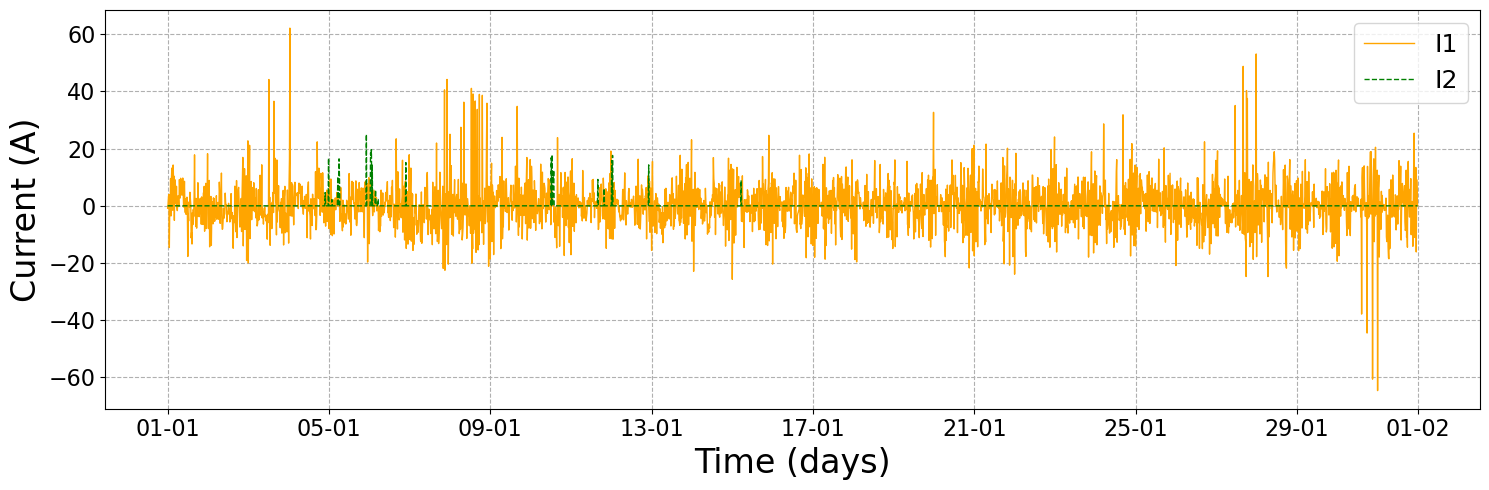

In [59]:

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
ax.plot(profile.index[:len(I1)], I1, label="I1", color="orange", linewidth=1)
ax.plot(profile.index[:len(I2)], I2, label="I2", color="green", linewidth=1, linestyle='--')
ax.set_xlabel("Time (days)",fontsize=24)
ax.set_ylabel("Current (A)",fontsize=24)
#ax.set_title("State of Charge Over Time")

# Add grid lines
ax.grid(True, linestyle='--')

# Add a legend
ax.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# Adjust layout
plt.tight_layout()

# Save the plot as a high-quality image (e.g., PNG or PDF)
plt.savefig("Current_equal.png", dpi=300, bbox_inches="tight")
#plt.savefig("Current_consq.png", dpi=300, bbox_inches="tight")
# Or, if you prefer to display the plot interactively, use plt.show()
# plt.show()


In [60]:
#profile1 = profile.drop(profile.index[-1])
fig = go.Figure()
fig.add_trace(go.Scatter(x=profile.index, y= ocv1, name="ocv1", line=dict(color="orange", dash="dot")))
fig.add_trace(go.Scatter(x=profile.index, y= ocv2, name="ocv2", line=dict(color="green", dash="dot")))
fig.add_trace(go.Scatter(x=profile.index, y= V1, name="V1", line=dict(color="orange")))
fig.add_trace(go.Scatter(x=profile.index, y= V2, name="V2", line=dict(color="green")))
fig.update_yaxes(title="Voltage (V)")
fig.update_xaxes(title="Time")
#fig.update_traces(line_shape="hv")
fig.update_layout(
  width=900,  # Specify the width in pixels
  height=500  # Specify the height in pixels
)
fig.show()

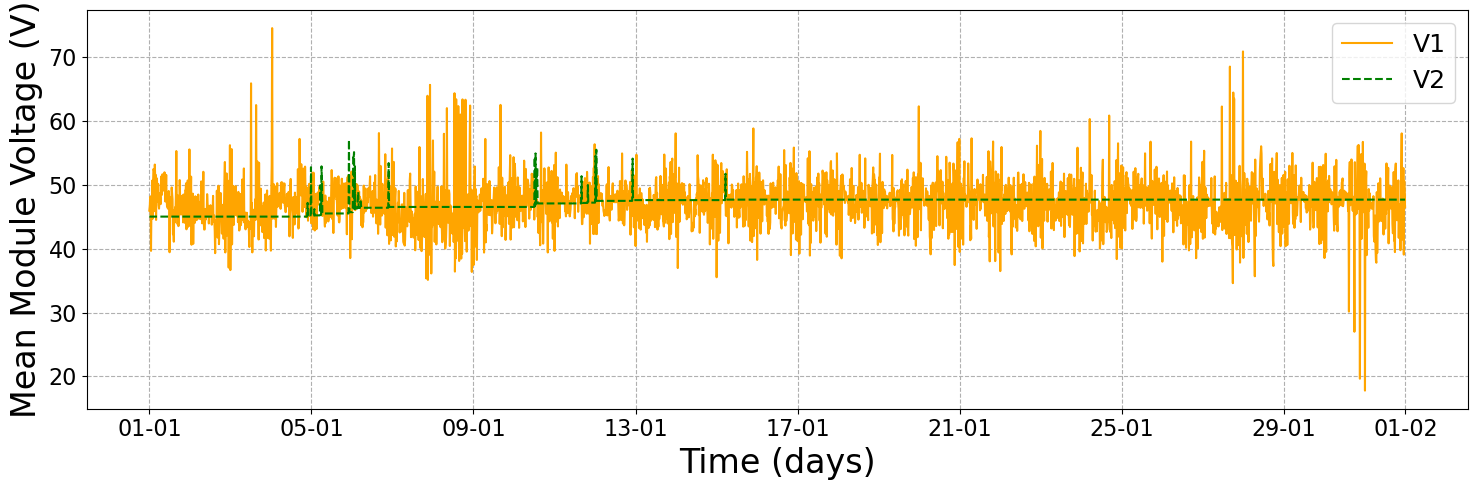

In [61]:

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
#ax.plot(profile.index[:len(ocv1)], ocv1, label="OCV1", color="orange", linewidth=1, linestyle='--')
#ax.plot(profile.index[:len(ocv1)], ocv2, label="OCV2", color="green", linewidth=1, linestyle='--')
ax.plot(profile.index[:len(V1)], V1, label="V1", color="orange", linewidth=1.5)
ax.plot(profile.index[:len(V2)], V2, label="V2", color="green", linewidth=1.5, linestyle='--')
# Set labels and title
ax.set_xlabel("Time (days)",fontsize=24)
ax.set_ylabel("Mean Module Voltage (V)", fontsize=24)
#ax.set_title("State of Charge Over Time")

# Add grid lines
ax.grid(True, linestyle='--')

# Add a legend
ax.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout
plt.tight_layout()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

# Save the plot as a high-quality image (e.g., PNG or PDF)
#plt.savefig("Terminal_Voltage_equal.png", dpi=300, bbox_inches="tight")
#plt.savefig("Module_Voltage_consq.png", dpi=300, bbox_inches="tight")
plt.savefig("Module_Voltage_equal.png", dpi=300, bbox_inches="tight")
# Or, if you prefer to display the plot interactively, use plt.show()
# plt.show()


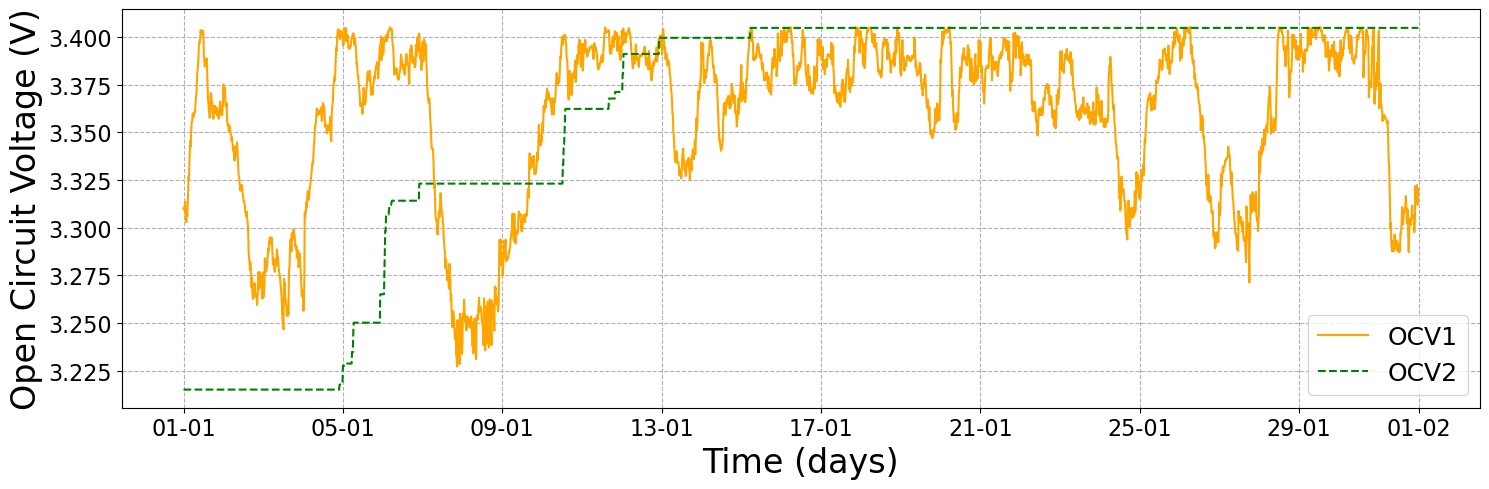

In [62]:

# Create a new figure
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data
ax.plot(profile.index[:len(ocv1)], ocv1, label="OCV1", color="orange", linewidth=1.5)
ax.plot(profile.index[:len(ocv1)], ocv2, label="OCV2", color="green", linewidth=1.5, linestyle='--')
# Set labels and title
ax.set_xlabel("Time (days)",fontsize=24)
ax.set_ylabel("Open Circuit Voltage (V)",fontsize=24)
#ax.set_title("State of Charge Over Time")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
# Add grid lines
ax.grid(True, linestyle='--')

# Add a legend
ax.legend(fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Adjust layout
plt.tight_layout()

# Save the plot as a high-quality image (e.g., PNG or PDF)
plt.savefig("OCV_equal.png", dpi=300, bbox_inches="tight")
#plt.savefig("OCV_consq.png", dpi=300, bbox_inches="tight")

# Or, if you prefer to display the plot interactively, use plt.show()
# plt.show()


In [63]:
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=profile.index, y=output.power_tu1, name="Power1"))
#fig.add_trace(go.Scatter(x=profile.index, y=output.power_tu2, name="Power2"))
#fig.update_yaxes(title="Power [kW]")
#fig.update_xaxes(title="time")
##fig.update_traces(line_shape="hv")
#fig.update_layout(
#  width=900,  # Specify the width in pixels
#  height=500  # Specify the height in pixels
#)
#fig.show()

In [64]:
#df = pd.read_csv(path_output1)
## Step 4: Add the new list as a new column to the DataFrame
#df['I1'] = I1
#df['I2'] = I2
#
## Step 5: Save the updated DataFrame back to the CSV file
#df.to_csv(path_output1, index=False)  

In [65]:
df = pd.read_csv(path_output)
# Step 4: Add the new list as a new column to the DataFrame
df['I1'] = I1
df['I2'] = I2
df['OCV1'] = ocv1
df['OCV2'] = ocv2
df['V1'] = V1
df['V2'] = V2

# Step 5: Save the updated DataFrame back to the CSV file
df.to_csv(path_output, index=False)  